# Music Recomendation using PCA, KMeans and Spotify's API

In [7]:
import pandas as pd
dados = pd.read_csv("Dados/Dados_totais.csv")
dados_genero = pd.read_csv("Dados/data_by_genres.csv")
dados_ano = pd.read_csv("Dados/data_by_year.csv")

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage import io

# getting access to spotify API with own client_id 
scope = "user-library-read playlist-modify-private"
OAuth = SpotifyOAuth(
    scope=scope,
    redirect_uri='http://localhost:8888/callback',
    client_id = "71689d287db24ffaaae53d7a4303d651",
    client_secret = "37c081f10a7347b6b8320474e8a90399"
)
client_id = "71689d287db24ffaaae53d7a4303d651" #this id is taken from my own app created at Spotify for Developers, "Maestro Spot".
client_secret = "37c081f10a7347b6b8320474e8a90399"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 

def get_url(playlist_id):
    url = []
    name = []
    release_date = []
    artists = []
    duration = []
    for i in playlist_id:
        track = sp.track(i)
        url.append(track["album"]["images"][1]["url"])
        name.append(track["name"])
        release_date.append(track["album"]["release_date"])
        artists.append(track['artists'][0]['name'])
        duration.append(round(track["duration_ms"]/60000, 2))
    return name, url, release_date, artists, duration

def visualize_songs(name, url):

    plt.figure(figsize=(15, 10))
    columns = 5
    for i, u in enumerate(url):
        ax = plt.subplot(len(url) // columns + 1, columns, i + 1)

        image = io.imread(u)

        plt.imshow(image)
        ax.get_yaxis().set_visible(False)
    
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(name[i], fontsize = 8)
        plt.tight_layout(h_pad=0.7, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.tick_params(bottom=False)
        plt.grid(visible=None)
        
    
    plt.show()

def recommend(name_song):
    # First step: include one hot encoders for the artists in the dataframe
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(dtype=int)
    colunas_ohe = ohe.fit_transform(dados[['artists']]).toarray()
    dados2 = dados.drop('artists', axis=1)
    dados1 = pd.DataFrame(colunas_ohe, columns=ohe.get_feature_names_out(['artists']))
    dados_dummies = pd.concat([dados2, dados1], axis=1)
    
    # Second Step: use dimensionality reduction using PCA
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    dados_dummies_int = dados_dummies.select_dtypes(include=numerics)
    pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=0.7))])
    music_embedding_pca = pca_pipeline.fit_transform(dados_dummies_int)
    projection_m = pd.DataFrame(data=music_embedding_pca)

    # Third Step: use K-Means to create the clusters
    kmeans_pca_pipeline = KMeans(n_clusters=50, verbose=False)
    kmeans_pca_pipeline.fit(projection_m)
    dados['cluster_pca'] = kmeans_pca_pipeline.predict(projection_m)
    projection_m['cluster_pca'] = kmeans_pca_pipeline.predict(projection_m)
    projection_m['artists'] = dados['artists']
    projection_m['song'] = dados['artists_song']

    # Fourth Step: compute euclidean distance between the given song and the recommendations
    from sklearn.metrics.pairwise import euclidean_distances

    projection_m.loc[projection_m['song'] == name_song]
    cluster = list(projection_m[projection_m['song'] == name_song]['cluster_pca'])[0]
    musicas_recomendadas = projection_m[projection_m['cluster_pca'] == cluster][[0, 1, 'cluster_pca', 'song']]
    
    x_musica = list(projection_m[projection_m['song'] == name_song][0])[0]
    y_musica = list(projection_m[projection_m['song'] == name_song][1])[0]

    distancias = euclidean_distances(musicas_recomendadas[[0, 1]], [[x_musica, y_musica]])
    musicas_recomendadas['id'] = dados['id']
    musicas_recomendadas['distancias'] = distancias
    
    recomendadas = musicas_recomendadas.sort_values('distancias').head(10)
    
    # Fifth Step: get url of recommended songs
    name, url, release_date, artists, duration = get_url(recomendadas['id'])
    
    # Sixth Step: return albums of recommended songs
    return list(zip(name, artists)), visualize_songs(name, url)


c:\Users\macvi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\macvi\AppData\Local\Temp/ipykernel_63848/1984592761.py:54: UserWarning: The figure layout has changed to tight
  plt.tight_layout(h_pad=0.7, w_pad=0)


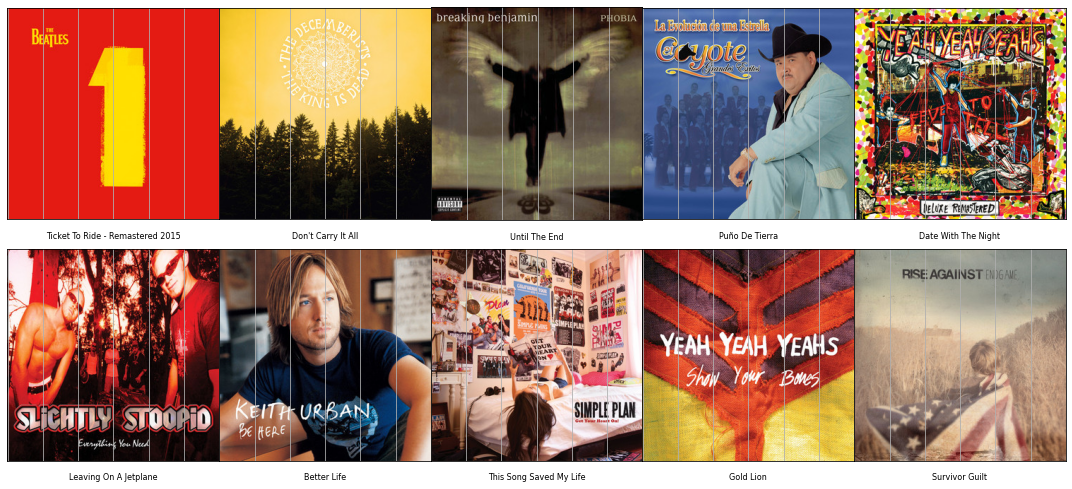

([('Ticket To Ride - Remastered 2015', 'The Beatles'),
  ("Don't Carry It All", 'The Decemberists'),
  ('Until The End', 'Breaking Benjamin'),
  ('Puño De Tierra', 'El Coyote Y Su Banda Tierra Santa'),
  ('Date With The Night', 'Yeah Yeah Yeahs'),
  ('Leaving On A Jetplane', 'Slightly Stoopid'),
  ('Better Life', 'Keith Urban'),
  ('This Song Saved My Life', 'Simple Plan'),
  ('Gold Lion', 'Yeah Yeah Yeahs'),
  ('Survivor Guilt', 'Rise Against')],
 None)

In [9]:
recommend("The Beatles - Ticket To Ride - Remastered 2015")

## How can I improve this recommendation system?

1 - process the input names and improve the query such that the song name doesn't need to necessarily be in the exact form as in spotify's data

2 - test different forms of dimensionality reduction (T-SNE, UMAP)

3 - include other factors for a song to be more favorable to be recommended (such as what else listeners are listening to, the time period the song belongs to, the genre)